In [1]:
from JupyterImport import *
from src.DatObject.Attributes import Transition as T, DatAttribute as DA
FitInfo = DA.FitInfo
root_logger.setLevel(logging.WARNING)

In [30]:
datnums = sorted(list(set(range(229, 341))-{342}))
dats = get_dats(datnums)
recalculate = True
dat_dict = {d.datnum: d for d in dats}

100% (112 of 112) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


In [35]:
width = 2000
fit_func = T.i_sense

def calc_new_fit(dat:DatHDF):
    x = dat.Transition.x
    idxs = CU.get_data_index(x, [-width, width])
    datas = dat.Transition.data[:, idxs[0]:idxs[1]]
    x = x[idxs[0]:idxs[1]]
    fs = T.transition_fits(x, datas, func=fit_func, auto_bin=True)
    if fs and None not in fs:
        all_fits = list()
        for f in fs:
            fi = FitInfo()
            fi.init_from_fit(f)
            all_fits.append(fi)
#         print(all_fits[0].best_values.theta)
        dat.Transition.all_fits = all_fits
        dat.Transition.set_avg_data()
        data = dat.Transition.avg_data[idxs[0]:idxs[1]]
        f = T.transition_fits(x, data, func=fit_func, auto_bin=True)[0]
        fit = FitInfo()
        fit.init_from_fit(f)
        dat.Other.trans_fit = fit
        dat.Other.update_HDF()
    else:
        dat.Other.trans_fit = None
    
for dat in progressbar(dats):
    if not hasattr(dat.Other, 'trans_fit') or dat.Other.trans_fit is None or recalculate is True:
        calc_new_fit(dat)

100% (112 of 112) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


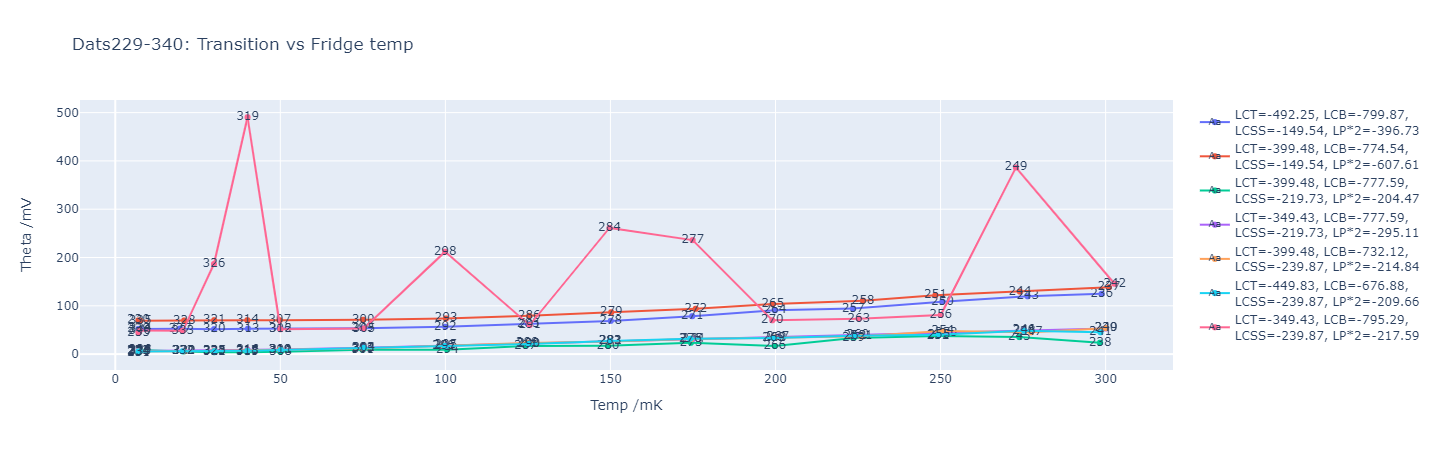

In [36]:
fig = go.Figure()
for i in range(7):
    ds = dats[i::7]
    ddict = {d.Logs.temps.mc: d for d in ds}
    ds = [ddict[k] for k in sorted(ddict)]
    temps = [dat.Logs.temps.mc*1000 for dat in ds]
    
    thetas = list()
    for dat in ds:
        if (f := dat.Other.trans_fit) is not None:
            thetas.append(f.best_values.theta)
        else:
            thetas.append(0)
#     thetas = [dat.Other.trans_fit.best_values.theta for dat in ds if]
#     thetas = [dat.Transition.avg_fit.best_values.theta for dat in ds]
    thetas = [t if t is not None else -1 for t in thetas]

    
    texts = [dat.datnum for dat in ds]
    fds = dat.Logs.fds
    name = f"LCT={fds['LCT']}, LCB={fds['LCB']},<br>LCSS={fds['LCSS']}, LP*2={fds['LP*2']}"
    fig.add_trace(go.Scatter(mode='markers+lines+text', x=temps, y=thetas, text=texts, name=name))
    
fig.update_layout(xaxis_title='Temp /mK', yaxis_title='Theta /mV', title=f'Dats{dats[0].datnum}-{dats[-1].datnum}: Transition vs Fridge temp')
fig

In [21]:
# fig.write_html(f'Dats{dats[0].datnum}-{dats[-1].datnum}--Transition vs Fridge temp.html')

Decimate_factor = 25
1000.0: 17.11
700.0: 17.05
400.0: 16.95
100.0: 16.90


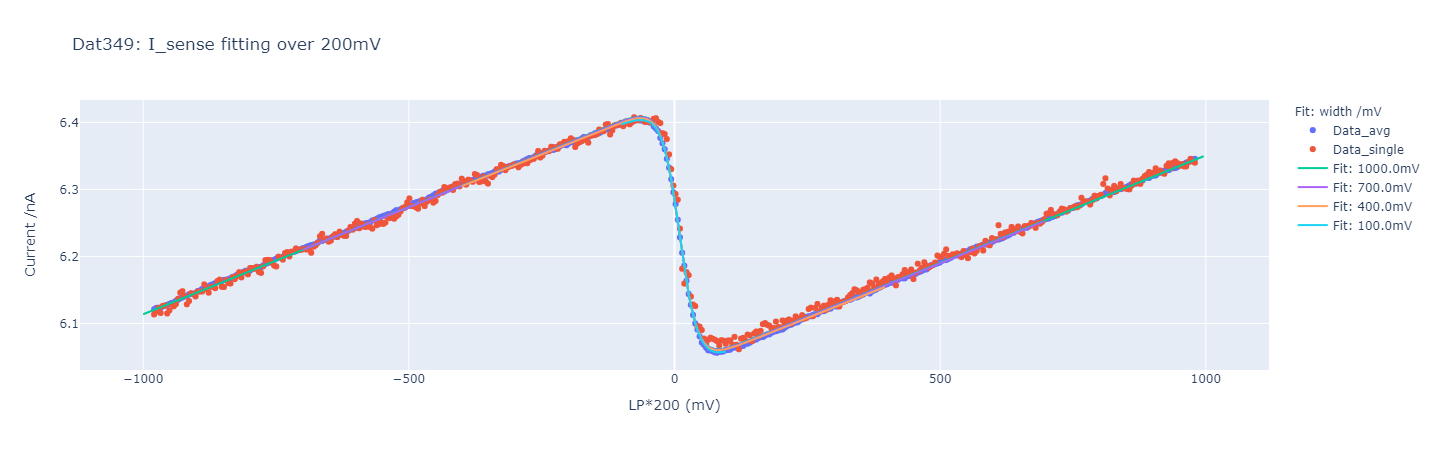

In [43]:
# dat = dat_dict[274]
dat = get_dat(349)
widths = np.linspace(1000, 100, 4)
fit_func = T.i_sense
decimate_factor = int(np.ceil(dat.Data.x_array.shape[-1]/500))  # Roughly 300 points per line
print(f'Decimate_factor = {decimate_factor}')

full_data_single = CU.decimate(dat.Transition.data[0] , dat.Logs.Fastdac.measure_freq, decimate_factor=decimate_factor)
full_data = CU.decimate(dat.Transition.avg_data , dat.Logs.Fastdac.measure_freq, decimate_factor=decimate_factor)
full_x = np.linspace(dat.Transition.x[0], dat.Transition.x[-1], full_data.shape[-1])
fig = go.Figure()
fig.add_trace(go.Scatter(mode='markers', x=full_x, y=full_data, name="Data_avg"))
fig.add_trace(go.Scatter(mode='markers', x=full_x, y=full_data_single, name="Data_single"))

# mid = dat.Transition.avg_fit.best_values.mid
# print(f'Avg fit mid initial guess: {mid:.0f}mV')
# if mid < full_x[0] or mid > full_x[-1]:
#     mid = np.mean(full_x)

mid = 0
for width in widths:
    idxs = CU.get_data_index(full_x, [mid-width, mid+width])

    data = full_data[idxs[0]:idxs[1]]
    x = full_x[idxs[0]:idxs[1]]
    x = np.linspace(x[0], x[-1], data.shape[-1])

    fit = FitInfo()
    try:
        f = T.transition_fits(x, data, func=fit_func)[0]
    except:
        f = None
    if f is not None:
        fit.init_from_fit(f)
        fig.add_trace(go.Scatter(mode='lines', x=x, y=fit.eval_fit(x=x), name=f'Fit: {width}mV'))
        print(f'{width}: {fit.best_values.theta:.2f}')
fig.update_layout(title=f'Dat{dat.datnum}: I_sense fitting over {width*2:.0f}mV', xaxis_title=dat.Logs.x_label, yaxis_title="Current /nA", legend_title='Fit: width /mV')